In [3]:
import pandas as pd
import numpy as np
import os

# Path to merged YOLOv8 keypoints dataset
csv_path = "/content/drive/MyDrive/CricVision/pose_keypoints_full.csv"

# Load dataset
df = pd.read_csv(csv_path)
print("Dataset loaded successfully.")
print(f"Total frames: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

# Quick inspection
display(df.head(3))

# Separate column groups
x_cols = [c for c in df.columns if "_x" in c]
y_cols = [c for c in df.columns if "_y" in c]
conf_cols = [c for c in df.columns if "_conf" in c]

print(f"\nX columns: {len(x_cols)}, Y columns: {len(y_cols)}, Confidence columns: {len(conf_cols)}")

# Check for missing values
missing = df.isnull().sum().sum()
if missing == 0:
    print("No missing values found.")
else:
    print(f"Found {missing} missing values in the dataset.")

# Confidence value sanity check
conf_min = df[conf_cols].min().min()
conf_max = df[conf_cols].max().max()
print(f"Confidence range: {conf_min:.3f} → {conf_max:.3f}")

# Basic coordinate sanity check
x_min, x_max = df[x_cols].min().min(), df[x_cols].max().max()
y_min, y_max = df[y_cols].min().min(), df[y_cols].max().max()
print(f"Coordinate range — X: {x_min:.1f}–{x_max:.1f}, Y: {y_min:.1f}–{y_max:.1f}")


Dataset loaded successfully.
Total frames: 32,492
Total columns: 52


,frame_name,kpt_0_x,kpt_0_y,kpt_0_conf,kpt_1_x,kpt_1_y,kpt_1_conf,kpt_2_x,kpt_2_y,kpt_2_conf,...,kpt_13_conf,kpt_14_x,kpt_14_y,kpt_14_conf,kpt_15_x,kpt_15_y,kpt_15_conf,kpt_16_x,kpt_16_y,kpt_16_conf
0,P1_V10_Phase1_frame217.jpg,58.451973,33.677799,0.806435,60.300720,31.771866,0.789120,58.021358,31.568640,0.186630,...,0.990535,84.017319,72.412704,0.985647,81.039078,92.301514,0.918506,87.830360,88.952797,0.909375
1,P1_V10_Phase1_frame218.jpg,72.664200,51.233082,0.776450,74.402832,49.340302,0.797032,71.206993,49.622059,0.307889,...,0.986735,72.049065,78.952530,0.966731,81.105911,94.810875,0.951324,71.620293,95.813599,0.909382
2,P1_V10_Phase1_frame219.jpg,60.680065,39.360443,0.875772,62.335114,36.862759,0.810537,58.236134,37.362576,0.670022,...,0.980258,65.353912,86.032341,0.969703,76.708977,101.588188,0.907775,65.797508,101.061539,0.878441



X columns: 17, Y columns: 17, Confidence columns: 17
No missing values found.
Confidence range: 0.000 → 1.000
Coordinate range — X: 0.0–128.0, Y: 0.0–128.0


In [5]:
import numpy as np
import pandas as pd

# Reload the keypoints data (optional, for clean start)
csv_path = "/content/drive/MyDrive/CricVision/pose_keypoints_full.csv"
df = pd.read_csv(csv_path)

x_cols = [c for c in df.columns if "_x" in c]
y_cols = [c for c in df.columns if "_y" in c]

norm_df = df.copy()

# Center around pelvis (hips)
pelvis_x = (df["kpt_11_x"] + df["kpt_12_x"]) / 2
pelvis_y = (df["kpt_11_y"] + df["kpt_12_y"]) / 2

for col in x_cols:
    norm_df[col] = df[col] - pelvis_x
for col in y_cols:
    norm_df[col] = df[col] - pelvis_y

# Use hip distance for scaling
hip_dist = np.sqrt((df["kpt_11_x"] - df["kpt_12_x"])**2 + (df["kpt_11_y"] - df["kpt_12_y"])**2)
scale = hip_dist.replace(0, np.nan).fillna(hip_dist.mean())

# Normalize coordinates by hip distance
for col in x_cols + y_cols:
    norm_df[col] = norm_df[col].div(scale, axis=0)

# Clip extreme outliers (e.g., high motion or partial detection)
norm_df[x_cols + y_cols] = norm_df[x_cols + y_cols].clip(-15, 15)

# Check new range
x_range = (norm_df[x_cols].min().min(), norm_df[x_cols].max().max())
y_range = (norm_df[y_cols].min().min(), norm_df[y_cols].max().max())

print("Cricket pose normalization complete (overwritten).")
print(f"Normalized coordinate range — X: {x_range[0]:.2f} to {x_range[1]:.2f}, Y: {y_range[0]:.2f} to {y_range[1]:.2f}")

# Overwrite the normalized file
output_path = "/content/drive/MyDrive/CricVision/pose_keypoints_normalized.csv"
norm_df.to_csv(output_path, index=False)
print(f"Existing normalized CSV overwritten at: {output_path}")


Cricket pose normalization complete (overwritten).
Normalized coordinate range — X: -15.00 to 15.00, Y: -15.00 to 15.00
Existing normalized CSV overwritten at: /content/drive/MyDrive/CricVision/pose_keypoints_normalized.csv


In [6]:
import pandas as pd
import numpy as np

# Load normalized data
csv_path = "/content/drive/MyDrive/CricVision/pose_keypoints_normalized.csv"
df = pd.read_csv(csv_path)

x_cols = [c for c in df.columns if "_x" in c]
y_cols = [c for c in df.columns if "_y" in c]

# Helper functions
def angle_between(p1, p2, p3):
    """Returns the angle (in degrees) at point p2 formed by p1-p2-p3."""
    a = np.array(p1) - np.array(p2)
    b = np.array(p3) - np.array(p2)
    cos_theta = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9)
    angle = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))
    return angle

def distance(p1, p2):
    """Euclidean distance between two points."""
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Extract coordinates for convenience
coords = {}
for i in range(17):
    coords[i] = list(zip(df[f"kpt_{i}_x"], df[f"kpt_{i}_y"]))

# Compute angles for key joints
angles = {
    "left_elbow_angle": [angle_between(coords[5][i], coords[7][i], coords[9][i]) for i in range(len(df))],
    "right_elbow_angle": [angle_between(coords[6][i], coords[8][i], coords[10][i]) for i in range(len(df))],
    "left_knee_angle": [angle_between(coords[11][i], coords[13][i], coords[15][i]) for i in range(len(df))],
    "right_knee_angle": [angle_between(coords[12][i], coords[14][i], coords[16][i]) for i in range(len(df))],
    "shoulder_angle": [angle_between(coords[5][i], coords[6][i], coords[8][i]) for i in range(len(df))],
    "hip_angle": [angle_between(coords[11][i], coords[12][i], coords[14][i]) for i in range(len(df))],
}

# Compute distances between key joints (relative limb lengths)
distances = {
    "left_arm_length": [distance(coords[5][i], coords[7][i]) + distance(coords[7][i], coords[9][i]) for i in range(len(df))],
    "right_arm_length": [distance(coords[6][i], coords[8][i]) + distance(coords[8][i], coords[10][i]) for i in range(len(df))],
    "left_leg_length": [distance(coords[11][i], coords[13][i]) + distance(coords[13][i], coords[15][i]) for i in range(len(df))],
    "right_leg_length": [distance(coords[12][i], coords[14][i]) + distance(coords[14][i], coords[16][i]) for i in range(len(df))],
    "torso_length": [distance(coords[5][i], coords[11][i]) for i in range(len(df))],
}

# Combine features into a new dataframe
feature_df = pd.DataFrame({**angles, **distances})
feature_df["frame_name"] = df["frame_name"]

print("Feature engineering complete.")
print(f"Generated {feature_df.shape[1]-1} features for {feature_df.shape[0]} frames.")

# Save engineered feature dataset
output_path = "/content/drive/MyDrive/CricVision/pose_features.csv"
feature_df.to_csv(output_path, index=False)
print(f"Feature dataset saved to: {output_path}")


Feature engineering complete.
Generated 11 features for 32492 frames.
Feature dataset saved to: /content/drive/MyDrive/CricVision/pose_features.csv


In [11]:
import pandas as pd
import re

features_path = "/content/drive/MyDrive/CricVision/pose_features.csv"
scores_path   = "/content/drive/MyDrive/CricVision/final_dataset.csv"
output_path   = "/content/drive/MyDrive/CricVision/training_dataset.csv"

features_df = pd.read_csv(features_path)
scores_df   = pd.read_csv(scores_path)

# Extract phase_id from the prefixed feature names
# Example: "P1_V10_Phase10_frame7022.jpg" → "P1_V10_Phase10"
def extract_phase(name):
    match = re.match(r"(P\d+_V\d+_Phase\d+)_frame\d+\.jpg", str(name))
    return match.group(1) if match else None

features_df["phase_id"] = features_df["frame_name"].apply(extract_phase)

# Clean frame_name for join
features_df["frame_name"] = features_df["frame_name"].apply(lambda x: re.search(r"(frame\d+\.jpg)", str(x)).group(1))
scores_df["frame_name"]   = scores_df["frame_name"].astype(str)

# Drop any rows where phase_id couldn't be parsed
features_df = features_df.dropna(subset=["phase_id"])

print(f"Unique (phase_id, frame_name) in features: {features_df[['phase_id','frame_name']].drop_duplicates().shape[0]}")
print(f"Unique (phase_id, frame_name) in scores:   {scores_df[['phase_id','frame_name']].drop_duplicates().shape[0]}")

# Merge on both keys
merged_df = pd.merge(scores_df, features_df, on=["phase_id","frame_name"], how="inner")

print(f"Merged dataset shape: {merged_df.shape}")

merged_df.to_csv(output_path, index=False)
print(f"Training dataset saved to: {output_path}")


Unique (phase_id, frame_name) in features: 32492
Unique (phase_id, frame_name) in scores:   34160
Merged dataset shape: (32492, 19)
Training dataset saved to: /content/drive/MyDrive/CricVision/training_dataset.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Load merged training dataset
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
df = pd.read_csv(data_path)
print(f"Training dataset shape: {df.shape}")

# Define features and targets
feature_cols = [
    "left_elbow_angle", "right_elbow_angle", "left_knee_angle", "right_knee_angle",
    "shoulder_angle", "hip_angle", "left_arm_length", "right_arm_length",
    "left_leg_length", "right_leg_length", "torso_length"
]
target_cols = ["score_1", "score_2", "score_3", "score_4", "score_5"]

X = df[feature_cols].values
y = df[target_cols].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model (Random Forest)
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate per score
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

for i, score in enumerate(target_cols):
    print(f"{score}: MAE={mae[i]:.3f}, RMSE={rmse[i]:.3f}, R²={r2[i]:.3f}")

# Overall metrics
print(f"\nAverage MAE: {np.mean(mae):.3f}")
print(f"Average RMSE: {np.mean(rmse):.3f}")
print(f"Average R²: {np.mean(r2):.3f}")


Training dataset shape: (32492, 19)
score_1: MAE=1.452, RMSE=1.925, R²=0.359
score_2: MAE=1.500, RMSE=1.988, R²=0.359
score_3: MAE=1.510, RMSE=2.033, R²=0.361
score_4: MAE=1.498, RMSE=2.000, R²=0.359
score_5: MAE=1.478, RMSE=1.980, R²=0.360

Average MAE: 1.487
Average RMSE: 1.985
Average R²: 0.359


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# === Load dataset ===
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
df = pd.read_csv(data_path)
print(f"Loaded training dataset: {df.shape}")

# === Feature and target columns ===
base_features = [
    "left_elbow_angle", "right_elbow_angle", "left_knee_angle", "right_knee_angle",
    "shoulder_angle", "hip_angle", "left_arm_length", "right_arm_length",
    "left_leg_length", "right_leg_length", "torso_length"
]
target_cols = ["score_1", "score_2", "score_3", "score_4", "score_5"]

# Sort for temporal order
df = df.sort_values(["phase_id", "frame_number"])

# === Compute deltas (velocity) and delta2 (acceleration) ===
for col in base_features:
    df[f"{col}_delta"] = df.groupby("phase_id")[col].diff().fillna(0)
    df[f"{col}_delta2"] = df.groupby("phase_id")[f"{col}_delta"].diff().fillna(0)

# Combine all features
feature_cols = base_features + [f"{col}_delta" for col in base_features] + [f"{col}_delta2" for col in base_features]

# Normalize features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Normalize targets 0–1
y_min = df[target_cols].min()
y_max = df[target_cols].max()
df[target_cols] = (df[target_cols] - y_min) / (y_max - y_min)

# === Build temporal sequences (with padding) ===
sequence_length = 8
sequences, targets = [], []

for phase_id, phase_df in df.groupby("phase_id"):
    X_phase = phase_df[feature_cols].values
    y_phase = phase_df[target_cols].values

    # Pad if too short
    if len(X_phase) < sequence_length:
        pad_len = sequence_length - len(X_phase)
        X_phase = np.concatenate([X_phase, np.repeat([X_phase[-1]], pad_len, axis=0)], axis=0)
        y_phase = np.concatenate([y_phase, np.repeat([y_phase[-1]], pad_len, axis=0)], axis=0)

    # Overlapping windows
    for i in range(len(X_phase) - sequence_length + 1):
        seq_x = X_phase[i:i + sequence_length]
        seq_y = y_phase[i + sequence_length - 1]
        sequences.append(seq_x)
        targets.append(seq_y)

X = np.array(sequences)
y = np.array(targets)
print(f"Prepared sequences: {X.shape}, Targets: {y.shape}")

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === Model ===
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1), input_shape=(X.shape[1], X.shape[2])),
    layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=['mae']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.summary()

# === Train ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=80,
    batch_size=64,
    verbose=1,
    callbacks=[callback]
)

# === Evaluate ===
y_pred = model.predict(X_test)

# Denormalize
y_pred_rescaled = y_pred * (y_max.values - y_min.values) + y_min.values
y_test_rescaled = y_test * (y_max.values - y_min.values) + y_min.values

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled, multioutput='raw_values'))
r2 = [r2_score(y_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(y_test_rescaled.shape[1])]

for i, score in enumerate(target_cols):
    print(f"{score}: MAE={mae[i]:.3f}, RMSE={rmse[i]:.3f}, R²={r2[i]:.3f}")

print(f"\nAverage MAE: {np.mean(mae):.3f}")
print(f"Average RMSE: {np.mean(rmse):.3f}")
print(f"Average R²: {np.mean(r2):.3f}")

model.save("/content/drive/MyDrive/CricVision/bilstm_pose_model_advanced.keras")
print("Advanced BiLSTM model saved to Drive.")


Loaded training dataset: (32492, 19)
Prepared sequences: (8482, 8, 33), Targets: (8482, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 8, 256)         │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,333 (1.36 MB)

 Trainable params: 355,333 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0802 - mae: 0.2392 - val_loss: 0.0732 - val_mae: 0.2281
Epoch 2/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0735 - mae: 0.2280 - val_loss: 0.0721 - val_mae: 0.2254
Epoch 3/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0720 - mae: 0.2247 - val_loss: 0.0727 - val_mae: 0.2270
Epoch 4/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0718 - mae: 0.2246 - val_loss: 0.0721 - val_mae: 0.2265
Epoch 5/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0709 - mae: 0.2226 - val_loss: 0.0709 - val_mae: 0.2215
Epoch 6/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0685 - mae: 0.2175 - val_loss: 0.0708 - val_mae: 0.2209
Epoch 7/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0677 - mae: 0.2163 - val_loss: 0.0708 - val_mae: 0.2223
Epoch 8/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0652 - mae: 0.2126 - val_loss: 0.0731 - val_mae: 0.2234
Epoch 9/80
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

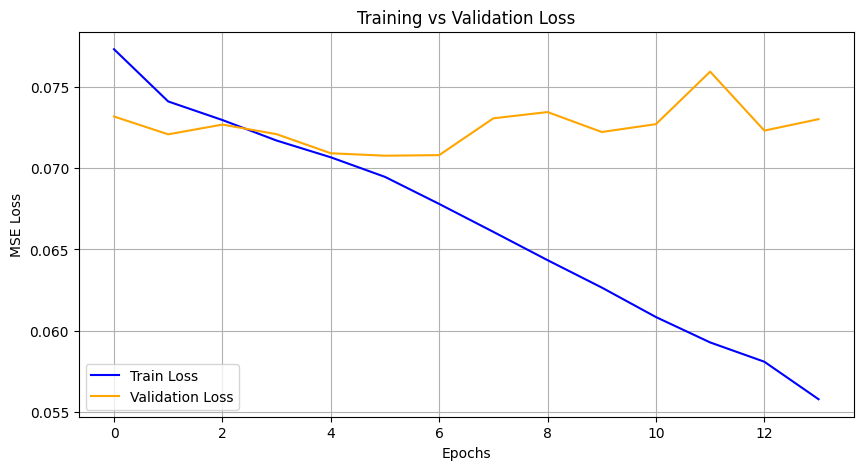

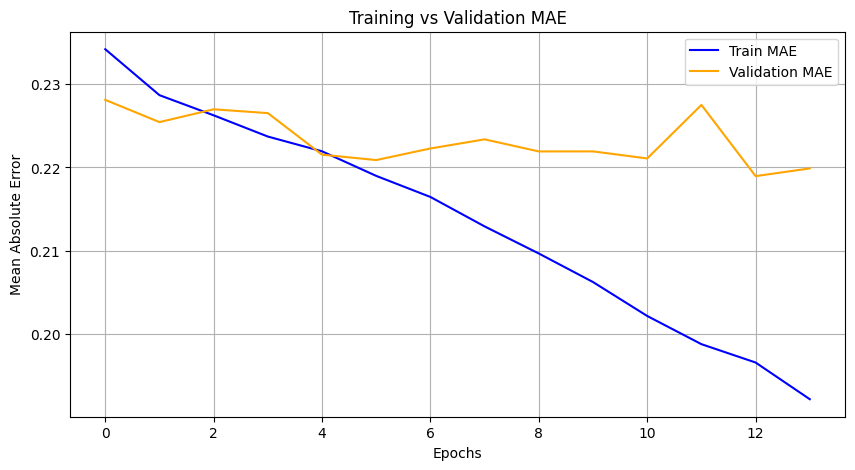

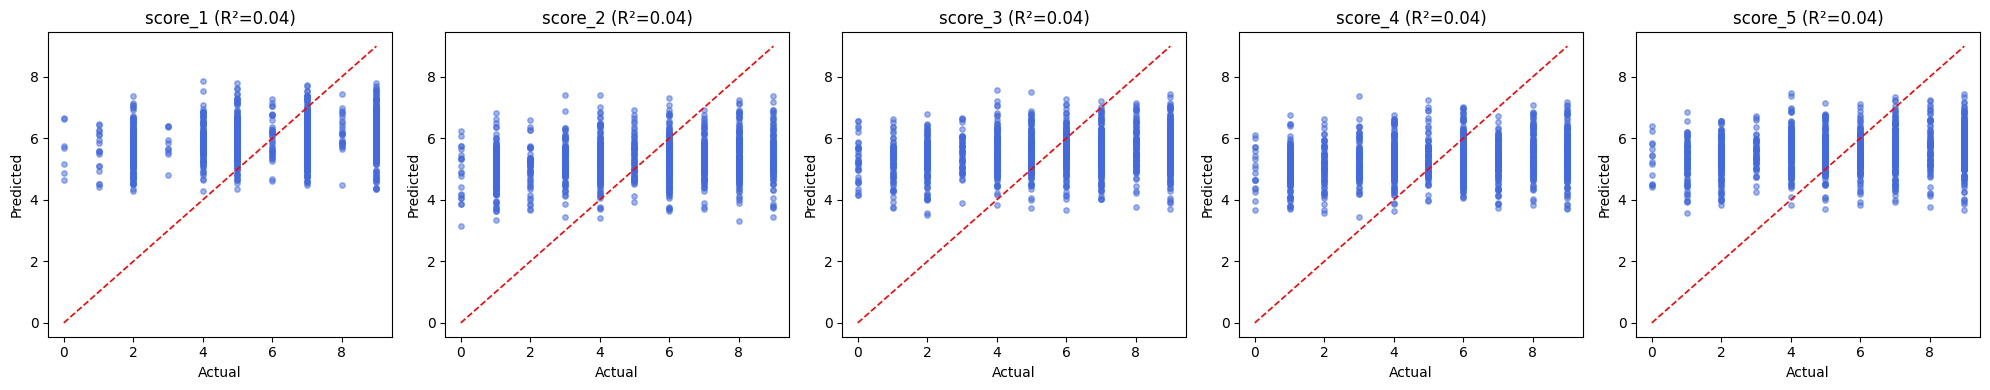

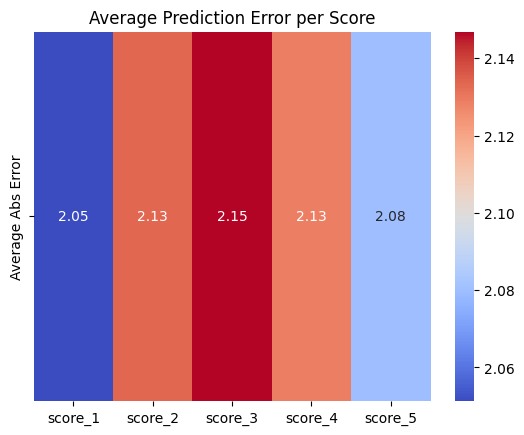

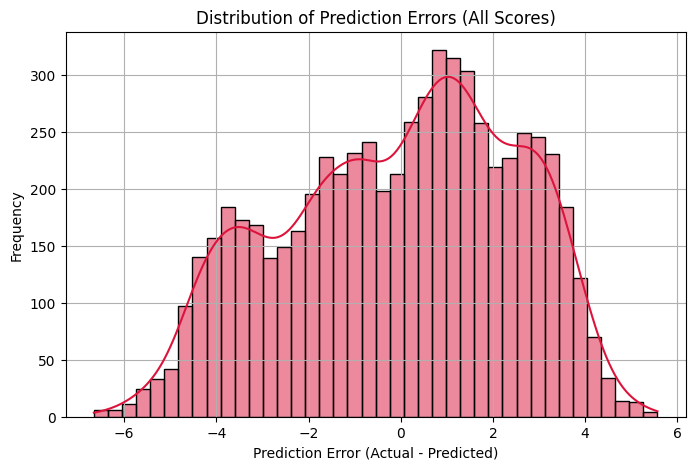

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# --- 1. Plot training & validation curves ---
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Train MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.title("Training vs Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Scatter plots: predicted vs actual scores ---
fig, axes = plt.subplots(1, 5, figsize=(20,4))
for i, score in enumerate(target_cols):
    axes[i].scatter(y_test_rescaled[:, i], y_pred_rescaled[:, i], alpha=0.5, s=15, color="royalblue")
    axes[i].plot([0, 9], [0, 9], 'r--', linewidth=1.2)  # perfect-fit line
    axes[i].set_title(f"{score} (R²={r2[i]:.2f})")
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")
plt.tight_layout()
plt.show()

# --- 3. Heatmap of prediction errors ---
errors = y_test_rescaled - y_pred_rescaled
error_df = np.abs(errors)
avg_error = error_df.mean(axis=0)
sns.heatmap(
    np.expand_dims(avg_error, axis=0),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=target_cols,
    yticklabels=["Average Abs Error"]
)
plt.title("Average Prediction Error per Score")
plt.show()

# --- 4. Error distribution across all scores ---
plt.figure(figsize=(8,5))
sns.histplot(errors.flatten(), bins=40, kde=True, color="crimson")
plt.title("Distribution of Prediction Errors (All Scores)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import pandas as pd
import cv2, os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === CONFIG ===
frames_root = "/content/drive/MyDrive/All_Frames"
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
save_model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_model_optimized.keras"

# === LOAD POSE DATA ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"])

pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]
targets = ["score_1","score_2","score_3","score_4","score_5"]

# === CNN MODEL ===
cnn_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((224,224,3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    return preprocess_input(img)

# === GPU-OPTIMIZED BATCHED EMBEDDING EXTRACTION ===
batch_size = 64
embeddings = []

frame_paths = [os.path.join(frames_root, row["phase_id"], row["frame_name"]) for _, row in df.iterrows()]

for i in tqdm(range(0, len(frame_paths), batch_size), desc="Extracting CNN features (batched)"):
    batch_imgs = [load_and_preprocess_image(p) for p in frame_paths[i:i+batch_size]]
    batch_imgs = np.array(batch_imgs, dtype=np.float32)
    emb_batch = cnn_model.predict(batch_imgs, verbose=0)
    embeddings.extend(emb_batch)

cnn_features = np.array(embeddings)
print("Extracted CNN embeddings:", cnn_features.shape)

# === COMBINE CNN + POSE FEATURES ===
scaler = StandardScaler()
pose_scaled = scaler.fit_transform(df[pose_features])

combined_features = np.concatenate([pose_scaled, cnn_features], axis=1)
print("Combined feature shape:", combined_features.shape)

# === CREATE SEQUENCES ===
sequence_length = 8
sequences, targets_seq = [], []

for phase_id, phase_df in df.groupby("phase_id"):
    X_phase = combined_features[phase_df.index]
    y_phase = df.loc[phase_df.index, targets].values

    if len(X_phase) < sequence_length:
        pad_len = sequence_length - len(X_phase)
        X_phase = np.concatenate([X_phase, np.repeat([X_phase[-1]], pad_len, axis=0)], axis=0)
        y_phase = np.concatenate([y_phase, np.repeat([y_phase[-1]], pad_len, axis=0)], axis=0)

    for i in range(len(X_phase) - sequence_length + 1):
        sequences.append(X_phase[i:i+sequence_length])
        targets_seq.append(y_phase[i+sequence_length-1])

X = np.array(sequences)
y = np.array(targets_seq)
print(f"Prepared sequences: {X.shape}, Targets: {y.shape}")

# === TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === HYBRID BiLSTM MODEL ===
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1),
                         input_shape=(X.shape[1], X.shape[2])),
    layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='mse', metrics=['mae'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                            restore_best_weights=True)

model.summary()

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# === EVALUATE ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

for i, s in enumerate(targets):
    print(f"{s}: MAE={mae[i]:.3f}, RMSE={rmse[i]:.3f}, R²={r2[i]:.3f}")
print(f"\nAverage MAE={np.mean(mae):.3f}, RMSE={np.mean(rmse):.3f}, R²={np.mean(r2):.3f}")

model.save(save_model_path)
print(f"Hybrid CNN+BiLSTM model saved to: {save_model_path}")


Extracting CNN features (batched): 100%|██████████| 508/508 [01:55<00:00,  4.40it/s]


Extracted CNN embeddings: (32492, 1280)
Combined feature shape: (32492, 1291)
Prepared sequences: (8482, 8, 1291), Targets: (8482, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 8, 256)         │     1,454,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,525 (6.27 MB)

 Trainable params: 1,643,525 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 12.1040 - mae: 2.8013 - val_loss: 6.0921 - val_mae: 2.1104
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.2328 - mae: 2.1174 - val_loss: 6.0365 - val_mae: 2.0720
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.2377 - mae: 2.1081 - val_loss: 6.2765 - val_mae: 2.1469
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.2037 - mae: 2.1055 - val_loss: 6.0551 - val_mae: 2.0987
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.2267 - mae: 2.1175 - val_loss: 6.0600 - val_mae: 2.1012
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.1977 - mae: 2.1007 - val_loss: 6.0398 - val_mae: 2.0703
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.1506 - mae: 2.0953 - val_loss: 6.0447 - val_mae: 2.0916
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.1116 - mae: 2.0820 - val_loss: 6.0597 - val_mae: 2.0601
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
from tqdm import tqdm

# === Paths ===
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_model_optimized.keras"

# === Load data and model ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)
print(f"Loaded dataset: {df.shape}")
print(f"Loading model from: {model_path}")

model = load_model(model_path)
print("Model loaded successfully.")

# === Feature setup (same as training) ===
pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]

# You can reuse the same feature scaling logic and CNN embeddings from before if stored,
# or rerun a small batched embedding extraction here if needed.

# === Create sequences exactly as during training ===
sequence_length = 8
features_root = "/content/drive/MyDrive/All_Frames"

# Helper to load combined features for inference
# (Here we assume you already have combined_features and targets from training context)
# If not, regenerate using the same steps as before (pose + CNN embedding merge)
# ---------------------------------------------------------------------
# For quick demonstration we use the existing merged feature generation
# ---------------------------------------------------------------------

# Recompute CNN + pose feature combination if not persisted
# (Optional: load from a saved .npy if you stored them)

# --- Combined features placeholder ---
# If you ran the previous cell in same runtime, you already have:
# combined_features, df
# Otherwise, reload precomputed npy arrays.

# === Prepare sequences for prediction ===
sequence_length = 8
phase_ids, sequences = [], []

# You should have combined_features ready (from previous step)
# If not, recompute it; otherwise uncomment below line:
# combined_features = np.load("/content/drive/MyDrive/CricVision/combined_features.npy")

for phase_id, phase_df in df.groupby("phase_id"):
    X_phase = combined_features[phase_df.index]
    if len(X_phase) < sequence_length:
        pad_len = sequence_length - len(X_phase)
        X_phase = np.concatenate([X_phase, np.repeat([X_phase[-1]], pad_len, axis=0)], axis=0)
    for i in range(len(X_phase) - sequence_length + 1):
        seq_x = X_phase[i:i + sequence_length]
        sequences.append(seq_x)
        phase_ids.append(phase_id)

X_all = np.array(sequences)
print(f"Sequences prepared for inference: {X_all.shape}")

# === Run inference on all sequences ===
y_pred = model.predict(X_all, verbose=1)

# Attach predictions to phase IDs
pred_df = pd.DataFrame(y_pred, columns=["pred_score_1","pred_score_2","pred_score_3","pred_score_4","pred_score_5"])
pred_df["phase_id"] = phase_ids

# === Aggregate predictions per phase ===
phase_pred = pred_df.groupby("phase_id")[["pred_score_1","pred_score_2","pred_score_3","pred_score_4","pred_score_5"]].mean().reset_index()
phase_true = df.groupby("phase_id")[["score_1","score_2","score_3","score_4","score_5"]].mean().reset_index()

merged = pd.merge(phase_true, phase_pred, on="phase_id", how="inner")
print(f"Merged per-phase results: {merged.shape}")

# === Evaluate phase-level performance ===
mae = mean_absolute_error(merged[["score_1","score_2","score_3","score_4","score_5"]],
                          merged[["pred_score_1","pred_score_2","pred_score_3","pred_score_4","pred_score_5"]],
                          multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(merged[["score_1","score_2","score_3","score_4","score_5"]],
                                  merged[["pred_score_1","pred_score_2","pred_score_3","pred_score_4","pred_score_5"]],
                                  multioutput='raw_values'))
r2 = [r2_score(merged[f"score_{i+1}"], merged[f"pred_score_{i+1}"]) for i in range(5)]

for i in range(5):
    print(f"score_{i+1}: MAE={mae[i]:.3f}, RMSE={rmse[i]:.3f}, R²={r2[i]:.3f}")

print(f"\nAverage MAE={np.mean(mae):.3f}, RMSE={np.mean(rmse):.3f}, R²={np.mean(r2):.3f}")

# Save aggregated predictions for visualization
output_csv = "/content/drive/MyDrive/CricVision/phase_level_predictions.csv"
merged.to_csv(output_csv, index=False)
print(f"Phase-level predictions saved to: {output_csv}")


Loaded dataset: (32492, 19)
Loading model from: /content/drive/MyDrive/CricVision/cnn_bilstm_model_optimized.keras
Model loaded successfully.
Sequences prepared for inference: (8482, 8, 1291)
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Merged per-phase results: (8482, 11)
score_1: MAE=2.061, RMSE=2.425, R²=-0.005
score_2: MAE=2.131, RMSE=2.501, R²=-0.002
score_3: MAE=2.122, RMSE=2.556, R²=-0.004
score_4: MAE=2.130, RMSE=2.527, R²=-0.004
score_5: MAE=2.074, RMSE=2.479, R²=-0.004

Average MAE=2.104, RMSE=2.498, R²=-0.004
Phase-level predictions saved to: /content/drive/MyDrive/CricVision/phase_level_predictions.csv


Loaded 8482 phase-level predictions
Average True Score: 5.48
Average Predicted Score: 5.63


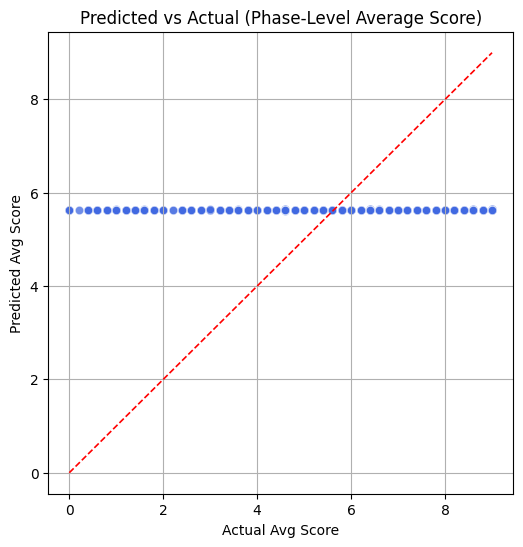

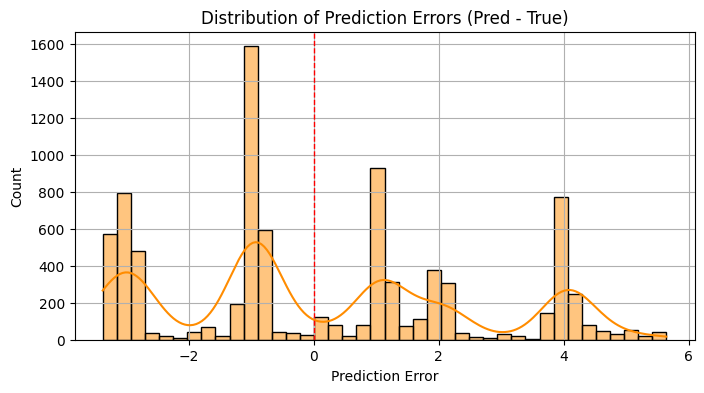

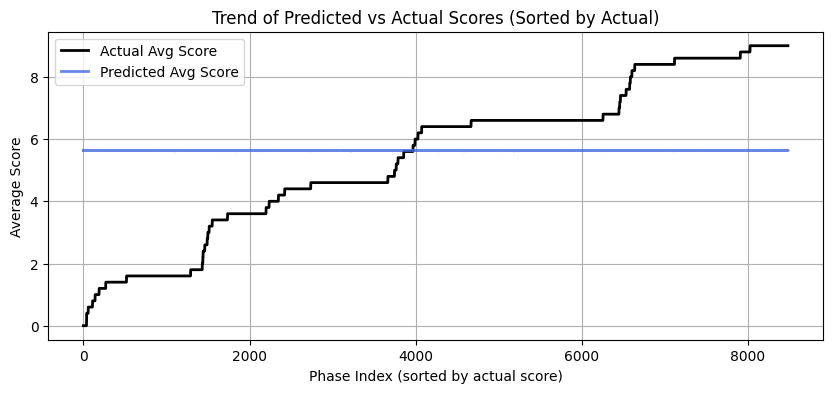

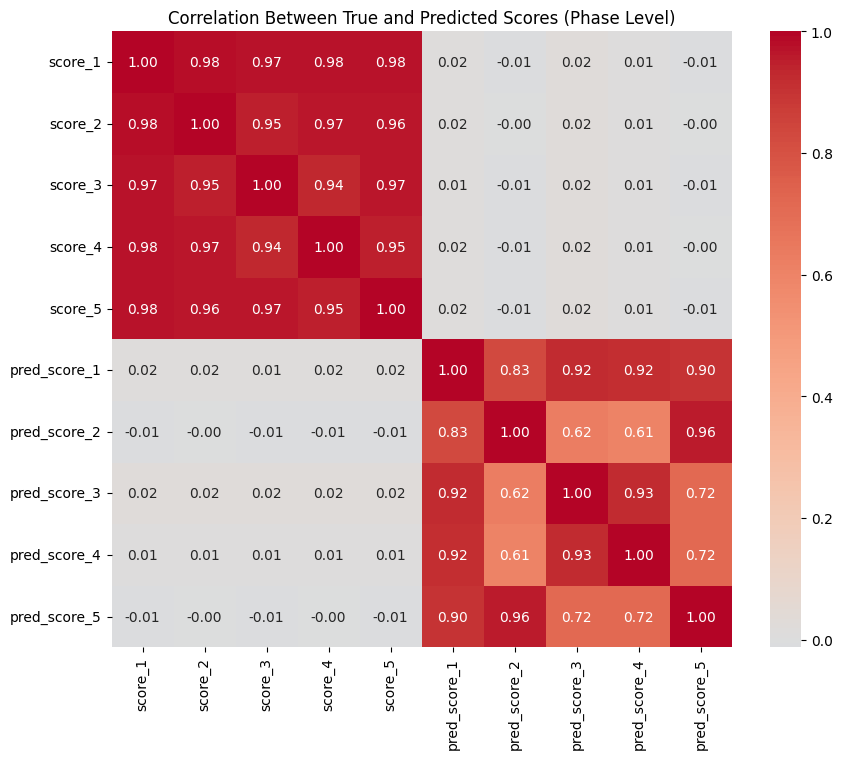

R² on average phase-level score: -0.004


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# === Load phase-level predictions ===
phase_results_path = "/content/drive/MyDrive/CricVision/phase_level_predictions.csv"
df_phase = pd.read_csv(phase_results_path)
print(f"Loaded {df_phase.shape[0]} phase-level predictions")

true_cols = ["score_1","score_2","score_3","score_4","score_5"]
pred_cols = ["pred_score_1","pred_score_2","pred_score_3","pred_score_4","pred_score_5"]

# === Compute averages for convenience ===
df_phase["true_avg"] = df_phase[true_cols].mean(axis=1)
df_phase["pred_avg"] = df_phase[pred_cols].mean(axis=1)
df_phase["error"] = df_phase["pred_avg"] - df_phase["true_avg"]

print("Average True Score:", round(df_phase["true_avg"].mean(), 2))
print("Average Predicted Score:", round(df_phase["pred_avg"].mean(), 2))

# === 1. Scatter plot: predicted vs actual (average) ===
plt.figure(figsize=(6,6))
sns.scatterplot(x="true_avg", y="pred_avg", data=df_phase, alpha=0.5, color="royalblue")
plt.plot([0, 9], [0, 9], 'r--', lw=1.2)
plt.title("Predicted vs Actual (Phase-Level Average Score)")
plt.xlabel("Actual Avg Score")
plt.ylabel("Predicted Avg Score")
plt.grid(True)
plt.show()

# === 2. Error histogram ===
plt.figure(figsize=(8,4))
sns.histplot(df_phase["error"], bins=40, kde=True, color="darkorange")
plt.axvline(0, color='red', linestyle='--', lw=1)
plt.title("Distribution of Prediction Errors (Pred - True)")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# === 3. Trend of predictions vs true (sorted) ===
sorted_df = df_phase.sort_values("true_avg").reset_index(drop=True)
plt.figure(figsize=(10,4))
plt.plot(sorted_df["true_avg"].values, label="Actual Avg Score", color="black", lw=2)
plt.plot(sorted_df["pred_avg"].values, label="Predicted Avg Score", color="royalblue", lw=2, alpha=0.8)
plt.title("Trend of Predicted vs Actual Scores (Sorted by Actual)")
plt.xlabel("Phase Index (sorted by actual score)")
plt.ylabel("Average Score")
plt.legend()
plt.grid(True)
plt.show()

# === 4. Correlation heatmap (per-score) ===
corr = df_phase[[*true_cols, *pred_cols]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between True and Predicted Scores (Phase Level)")
plt.show()

# === 5. R² on average scores ===
r2_avg = r2_score(df_phase["true_avg"], df_phase["pred_avg"])
print(f"R² on average phase-level score: {r2_avg:.3f}")


Loaded dataset: (32492, 19)
label_class
High      17116
Medium     9604
Low        5772
Name: count, dtype: int64


Extracting CNN features: 100%|██████████| 508/508 [01:36<00:00,  5.24it/s]


Extracted CNN embeddings: (32492, 1280)
Combined feature shape: (32492, 1291)
Prepared sequences: (8482, 8, 1291), Labels: (8482, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 8, 256)         │     1,454,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,395 (6.27 MB)

 Trainable params: 1,643,395 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5285 - loss: 1.0140 - val_accuracy: 0.5479 - val_loss: 1.0024
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5163 - loss: 1.0141 - val_accuracy: 0.5479 - val_loss: 0.9853
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5292 - loss: 1.0047 - val_accuracy: 0.5479 - val_loss: 0.9827
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5198 - loss: 1.0123 - val_accuracy: 0.5479 - val_loss: 0.9817
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5204 - loss: 1.0021 - val_accuracy: 0.5479 - val_loss: 0.9806
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5189 - loss: 1.0092 - val_accuracy: 0.5479 - val_loss: 0.9806
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5147 - loss: 1.0116 - val_accuracy: 0.5479 - val_loss: 0.9809
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5134 - loss: 1.0078 - val_accu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


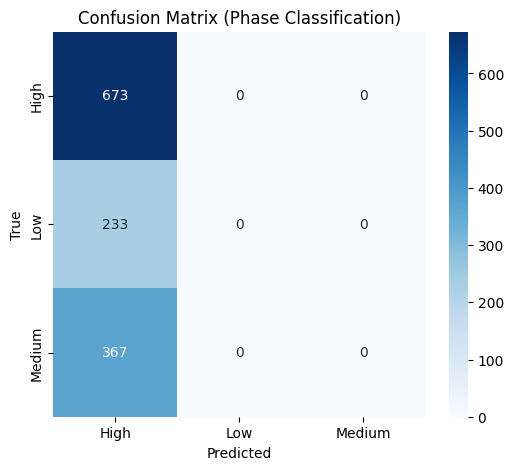

Classification model saved to: /content/drive/MyDrive/CricVision/cnn_bilstm_classifier.keras


In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import cv2, os
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# === CONFIG ===
frames_root = "/content/drive/MyDrive/All_Frames"
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
save_model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_classifier.keras"

# === LOAD AND PREPARE DATA ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)
print(f"Loaded dataset: {df.shape}")

# --- Convert numeric scores into 3 classes based on average score ---
score_cols = ["score_1","score_2","score_3","score_4","score_5"]
df["avg_score"] = df[score_cols].mean(axis=1)

def label_from_score(x):
    if x <= 3: return "Low"
    elif x <= 6: return "Medium"
    else: return "High"

df["label_class"] = df["avg_score"].apply(label_from_score)
print(df["label_class"].value_counts())

# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label_class"])
y_classes = to_categorical(df["label_encoded"], num_classes=3)

# === CNN MODEL (EfficientNetB0) ===
cnn_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((224,224,3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    return preprocess_input(img)

# === BATCHED CNN EMBEDDING EXTRACTION ===
batch_size = 64
embeddings = []
frame_paths = [os.path.join(frames_root, row["phase_id"], row["frame_name"]) for _, row in df.iterrows()]

for i in tqdm(range(0, len(frame_paths), batch_size), desc="Extracting CNN features"):
    batch_imgs = [load_and_preprocess_image(p) for p in frame_paths[i:i+batch_size]]
    batch_imgs = np.array(batch_imgs, dtype=np.float32)
    emb_batch = cnn_model.predict(batch_imgs, verbose=0)
    embeddings.extend(emb_batch)

cnn_features = np.array(embeddings)
print("Extracted CNN embeddings:", cnn_features.shape)

# === COMBINE POSE FEATURES ===
pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]
scaler = StandardScaler()
pose_scaled = scaler.fit_transform(df[pose_features])

combined_features = np.concatenate([pose_scaled, cnn_features], axis=1)
print("Combined feature shape:", combined_features.shape)

# === CREATE TEMPORAL SEQUENCES ===
sequence_length = 8
sequences, labels = [], []

for phase_id, phase_df in df.groupby("phase_id"):
    X_phase = combined_features[phase_df.index]
    y_phase = y_classes[phase_df.index]
    if len(X_phase) < sequence_length:
        pad_len = sequence_length - len(X_phase)
        X_phase = np.concatenate([X_phase, np.repeat([X_phase[-1]], pad_len, axis=0)], axis=0)
        y_phase = np.concatenate([y_phase, np.repeat([y_phase[-1]], pad_len, axis=0)], axis=0)
    for i in range(len(X_phase) - sequence_length + 1):
        seq_x = X_phase[i:i + sequence_length]
        seq_y = y_phase[i + sequence_length - 1]
        sequences.append(seq_x)
        labels.append(seq_y)

X = np.array(sequences)
y = np.array(labels)
print(f"Prepared sequences: {X.shape}, Labels: {y.shape}")

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === MODEL ===
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1), input_shape=(X.shape[1], X.shape[2])),
    layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.summary()

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

# === EVALUATE ===
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Phase Classification)")
plt.show()

model.save(save_model_path)
print(f"Classification model saved to: {save_model_path}")


In [24]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df["label_encoded"])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["label_encoded"])
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# Then pass to fit()
model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[callback],
    class_weight=class_weights
)


Class weights: {np.int64(0): np.float64(0.6327802446054374), np.int64(1): np.float64(1.8764148764148765), np.int64(2): np.float64(1.1277245592114398)}
Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4490 - loss: 1.1034 - val_accuracy: 0.3370 - val_loss: 1.1102
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3895 - loss: 1.0833 - val_accuracy: 0.4397 - val_loss: 1.0560
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3964 - loss: 1.0833 - val_accuracy: 0.3176 - val_loss: 1.0985
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3860 - loss: 1.0798 - val_accuracy: 0.3786 - val_loss: 1.0794
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3981 - loss: 1.0865 - val_accuracy: 0.3523 - val_loss: 1.1113
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4253 - loss: 1.0625 - val_accuracy: 0.3037 - val_loss: 1.1109
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3919 - l

Running inference on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report (with class weighting):
              precision    recall  f1-score   support

        High       0.58      0.49      0.53       673
         Low       0.22      0.21      0.22       233
      Medium       0.30      0.40      0.34       367

    accuracy                           0.41      1273
   macro avg       0.37      0.37      0.36      1273
weighted avg       0.43      0.41      0.42      1273



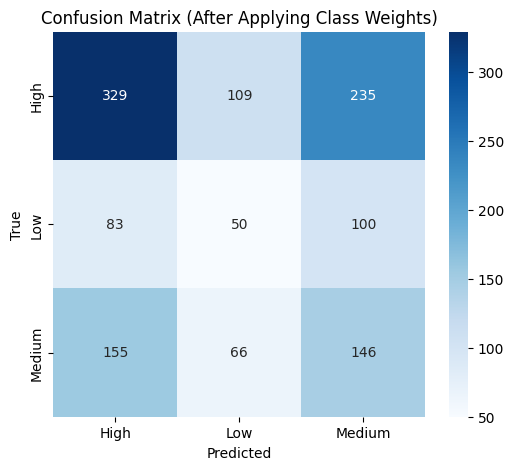


Predicted class distribution: {'High': np.int64(567), 'Low': np.int64(225), 'Medium': np.int64(481)}


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Evaluate model ===
print("Running inference on test set...")
y_pred = model.predict(X_test, verbose=1)

# Convert from one-hot to label indices
y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# === Classification report ===
print("\nClassification Report (with class weighting):")
print(classification_report(y_true, y_pred_labels, target_names=label_encoder.classes_))

# === Confusion matrix ===
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (After Applying Class Weights)")
plt.show()

# === Optional: Class distribution check ===
unique, counts = np.unique(y_pred_labels, return_counts=True)
pred_dist = dict(zip(label_encoder.inverse_transform(unique), counts))
print("\nPredicted class distribution:", pred_dist)


Label distribution:
 label_class
High      17116
Medium     9604
Low        5772
Name: count, dtype: int64
Added motion_energy column (sample):
0       0.000000
1    5359.194354
2    3099.445132
3    3760.480382
4       0.000000
Name: motion_energy, dtype: float64


Extracting CNN features: 100%|██████████| 508/508 [01:40<00:00,  5.04it/s]


Extracted CNN embeddings: (32492, 1280)
Combined feature shape: (32492, 1292)
Prepared sequences: (8482, 8, 1292), Labels: (8482, 3)
Class weights: {np.int64(0): np.float64(0.6327802446054374), np.int64(1): np.float64(1.8764148764148765), np.int64(2): np.float64(1.1277245592114398)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 8, 256)         │     1,455,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,644,419 (6.27 MB)

 Trainable params: 1,644,419 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3164 - loss: 1.1169 - val_accuracy: 0.2871 - val_loss: 1.0935
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3559 - loss: 1.1059 - val_accuracy: 0.1942 - val_loss: 1.1338
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3522 - loss: 1.0890 - val_accuracy: 0.3190 - val_loss: 1.1106
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3347 - loss: 1.1048 - val_accuracy: 0.4286 - val_loss: 1.0798
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3043 - loss: 1.1111 - val_accuracy: 0.3121 - val_loss: 1.1156
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3493 - loss: 1.0969 - val_accuracy: 0.2067 - val_loss: 1.1550
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3327 - loss: 1.0988 - val_accuracy: 0.2774 - val_loss: 1.1278
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3371 - loss: 1.1043 - val_accu

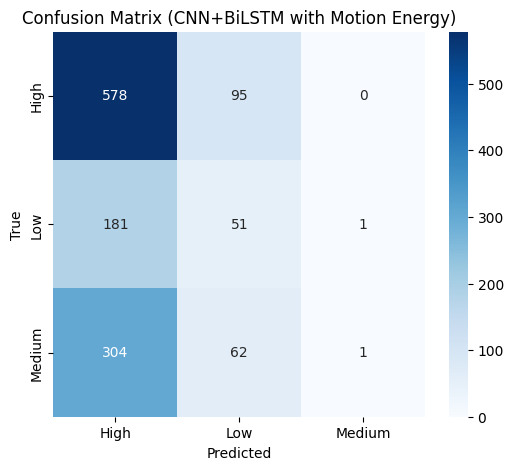

Model with motion energy saved to: /content/drive/MyDrive/CricVision/cnn_bilstm_motion_classifier.keras


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import cv2, os
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# === CONFIG ===
frames_root = "/content/drive/MyDrive/All_Frames"
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
save_model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_motion_classifier.keras"

# === LOAD DATA ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)

pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]

score_cols = ["score_1","score_2","score_3","score_4","score_5"]
df["avg_score"] = df[score_cols].mean(axis=1)

# === Convert scores into classes ===
def label_from_score(x):
    if x <= 3: return "Low"
    elif x <= 6: return "Medium"
    else: return "High"

df["label_class"] = df["avg_score"].apply(label_from_score)
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label_class"])
y_classes = to_categorical(df["label_encoded"], num_classes=3)
print("Label distribution:\n", df["label_class"].value_counts())

# === Add Motion Energy Feature ===
# Motion energy measures how much pose angles change between frames
motion_energy = df.groupby("phase_id")[pose_features].diff().pow(2).sum(axis=1).fillna(0)
df["motion_energy"] = motion_energy
print("Added motion_energy column (sample):")
print(df["motion_energy"].head())

# === CNN MODEL ===
cnn_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((224,224,3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    return preprocess_input(img)

# === CNN FEATURE EXTRACTION (BATCHED) ===
batch_size = 64
embeddings = []
frame_paths = [os.path.join(frames_root, row["phase_id"], row["frame_name"]) for _, row in df.iterrows()]

for i in tqdm(range(0, len(frame_paths), batch_size), desc="Extracting CNN features"):
    batch_imgs = [load_and_preprocess_image(p) for p in frame_paths[i:i+batch_size]]
    batch_imgs = np.array(batch_imgs, dtype=np.float32)
    emb_batch = cnn_model.predict(batch_imgs, verbose=0)
    embeddings.extend(emb_batch)

cnn_features = np.array(embeddings)
print("Extracted CNN embeddings:", cnn_features.shape)

# === COMBINE CNN + POSE + MOTION FEATURES ===
scaler = StandardScaler()
pose_scaled = scaler.fit_transform(df[pose_features + ["motion_energy"]])
combined_features = np.concatenate([pose_scaled, cnn_features], axis=1)
print("Combined feature shape:", combined_features.shape)

# === CREATE SEQUENCES ===
sequence_length = 8
sequences, labels = [], []

for phase_id, phase_df in df.groupby("phase_id"):
    X_phase = combined_features[phase_df.index]
    y_phase = y_classes[phase_df.index]
    if len(X_phase) < sequence_length:
        pad_len = sequence_length - len(X_phase)
        X_phase = np.concatenate([X_phase, np.repeat([X_phase[-1]], pad_len, axis=0)], axis=0)
        y_phase = np.concatenate([y_phase, np.repeat([y_phase[-1]], pad_len, axis=0)], axis=0)
    for i in range(len(X_phase) - sequence_length + 1):
        seq_x = X_phase[i:i + sequence_length]
        seq_y = y_phase[i + sequence_length - 1]
        sequences.append(seq_x)
        labels.append(seq_y)

X = np.array(sequences)
y = np.array(labels)
print(f"Prepared sequences: {X.shape}, Labels: {y.shape}")

# === CLASS WEIGHTS ===
classes = np.unique(df["label_encoded"])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["label_encoded"])
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === MODEL ===
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1), input_shape=(X.shape[1], X.shape[2])),
    layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.summary()

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[callback],
    class_weight=class_weights
)

# === EVALUATE ===
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report (with Motion Energy):")
print(classification_report(y_true, y_pred_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (CNN+BiLSTM with Motion Energy)")
plt.show()

model.save(save_model_path)
print(f"Model with motion energy saved to: {save_model_path}")


Label distribution:
 label_class
High      17116
Medium     9604
Low        5772
Name: count, dtype: int64


Computing optical flow: 100%|██████████| 8482/8482 [00:05<00:00, 1630.16it/s]


Added optical flow columns.


Extracting CNN features: 100%|██████████| 508/508 [01:40<00:00,  5.03it/s]


Combined features: (32492, 1294)
Sequences: (8482, 8, 1294)
Class weights: {np.int64(0): np.float64(0.6327802446054374), np.int64(1): np.float64(1.8764148764148765), np.int64(2): np.float64(1.1277245592114398)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3097 - loss: 1.1161 - val_accuracy: 0.2705 - val_loss: 1.1175
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2852 - loss: 1.1080 - val_accuracy: 0.2691 - val_loss: 1.1117
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3486 - loss: 1.0992 - val_accuracy: 0.1720 - val_loss: 1.1216
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3282 - loss: 1.1002 - val_accuracy: 0.2205 - val_loss: 1.1079
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3479 - loss: 1.0997 - val_accuracy: 0.2954 - val_loss: 1.1055
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3347 - loss: 1.0994 - val_accuracy: 0.5423 - val_loss: 1.0606
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3751 - loss: 1.1020 - val_accuracy: 0.2677 - val_loss: 1.1008
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3369 - loss: 1.1010 - val_accu

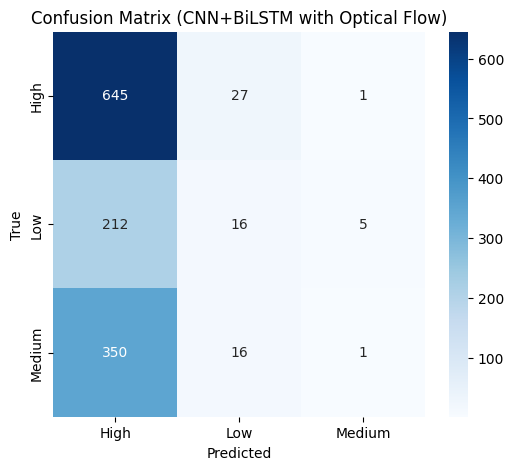

Model with optical flow saved to: /content/drive/MyDrive/CricVision/cnn_bilstm_opticalflow_classifier.keras


In [28]:
import cv2, os, numpy as np, pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# === CONFIG ===
frames_root = "/content/drive/MyDrive/All_Frames"
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
save_model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_opticalflow_classifier.keras"

# === LOAD & PREP DATA ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)

pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]
score_cols = ["score_1","score_2","score_3","score_4","score_5"]
df["avg_score"] = df[score_cols].mean(axis=1)

def label_from_score(x):
    if x <= 3: return "Low"
    elif x <= 6: return "Medium"
    else: return "High"

df["label_class"] = df["avg_score"].apply(label_from_score)
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label_class"])
y_classes = to_categorical(df["label_encoded"], num_classes=3)
print("Label distribution:\n", df["label_class"].value_counts())

# === Compute optical flow magnitude per frame ===
def optical_flow_magnitude(prev_img, next_img):
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    return np.mean(mag), np.std(mag)

magnitudes, stds = [], []
for phase_id, phase_df in tqdm(df.groupby("phase_id"), desc="Computing optical flow"):
    frame_files = [os.path.join(frames_root, phase_id, fn) for fn in phase_df["frame_name"]]
    phase_mags, phase_stds = [0], [0]   # pad first frame
    for i in range(1, len(frame_files)):
        img1 = cv2.imread(frame_files[i-1])
        img2 = cv2.imread(frame_files[i])
        if img1 is None or img2 is None:
            phase_mags.append(0)
            phase_stds.append(0)
            continue
        m, s = optical_flow_magnitude(img1, img2)
        phase_mags.append(m)
        phase_stds.append(s)
    magnitudes.extend(phase_mags)
    stds.extend(phase_stds)

df["flow_mag_mean"] = magnitudes
df["flow_mag_std"] = stds
print("Added optical flow columns.")

# === CNN embeddings (same as before) ===
cnn_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

def load_img(p):
    im = cv2.imread(p)
    if im is None: return np.zeros((224,224,3), np.float32)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (224,224))
    return preprocess_input(im)

batch, embs = 64, []
paths = [os.path.join(frames_root, r["phase_id"], r["frame_name"]) for _,r in df.iterrows()]
for i in tqdm(range(0, len(paths), batch), desc="Extracting CNN features"):
    imgs = np.array([load_img(p) for p in paths[i:i+batch]], np.float32)
    embs.extend(cnn_model.predict(imgs, verbose=0))
cnn_features = np.array(embs)

# === Combine pose + motion + flow + CNN ===
motion_energy = df.groupby("phase_id")[pose_features].diff().pow(2).sum(axis=1).fillna(0)
df["motion_energy"] = motion_energy
scaler = StandardScaler()
pose_scaled = scaler.fit_transform(df[pose_features + ["motion_energy","flow_mag_mean","flow_mag_std"]])
combined = np.concatenate([pose_scaled, cnn_features], axis=1)
print("Combined features:", combined.shape)

# === Create sequences ===
seq_len = 8
seqs, labels = [], []
for pid, ph in df.groupby("phase_id"):
    Xp, yp = combined[ph.index], y_classes[ph.index]
    if len(Xp)<seq_len:
        pad = seq_len-len(Xp)
        Xp=np.concatenate([Xp,np.repeat([Xp[-1]],pad,0)],0)
        yp=np.concatenate([yp,np.repeat([yp[-1]],pad,0)],0)
    for i in range(len(Xp)-seq_len+1):
        seqs.append(Xp[i:i+seq_len]); labels.append(yp[i+seq_len-1])
X, y = np.array(seqs), np.array(labels)
print("Sequences:", X.shape)

# === Class weights (Fixed) ===
classes = np.unique(df["label_encoded"])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["label_encoded"])
cw = dict(zip(classes, weights))
print("Class weights:", cw)


# === Train/test split ===
Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.15,random_state=42)

# === Model ===
model=models.Sequential([
    layers.Bidirectional(layers.LSTM(128,return_sequences=True,dropout=0.1),input_shape=(X.shape[1],X.shape[2])),
    layers.Bidirectional(layers.LSTM(64,dropout=0.1)),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),loss='categorical_crossentropy',metrics=['accuracy'])
cb=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

history=model.fit(Xtr,ytr,validation_split=0.1,epochs=50,batch_size=32,verbose=1,class_weight=cw,callbacks=[cb])

# === Evaluate ===
y_pred=model.predict(Xte)
y_true=np.argmax(yte,1); y_hat=np.argmax(y_pred,1)
print("\nClassification Report (with Optical Flow):")
print(classification_report(y_true,y_hat,target_names=le.classes_))
cm=confusion_matrix(y_true,y_hat)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
            xticklabels=le.classes_,yticklabels=le.classes_)
plt.xlabel("Predicted");plt.ylabel("True")
plt.title("Confusion Matrix (CNN+BiLSTM with Optical Flow)");plt.show()
model.save(save_model_path)
print(f"Model with optical flow saved to: {save_model_path}")


#Best Model Below Cell

Label distribution:
 label_class
High        17116
Not_High    15376
Name: count, dtype: int64


Computing optical flow: 100%|██████████| 8482/8482 [00:05<00:00, 1568.97it/s]


Added motion and optical flow features.


Extracting CNN features: 100%|██████████| 508/508 [01:38<00:00,  5.14it/s]


Extracted CNN embeddings: (32492, 1280)
Combined feature shape: (32492, 1294)
Sequences: (8482, 8, 1294)
Class weights: {np.int64(0): np.float64(0.9491703669081561), np.int64(1): np.float64(1.0565816857440167)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 8, 256)         │     1,457,152 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,646,402 (6.28 MB)

 Trainable params: 1,646,402 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4965 - loss: 0.6967 - val_accuracy: 0.4563 - val_loss: 0.6941
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4891 - loss: 0.6941 - val_accuracy: 0.4508 - val_loss: 0.6938
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4927 - loss: 0.6952 - val_accuracy: 0.4521 - val_loss: 0.6943
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4923 - loss: 0.6936 - val_accuracy: 0.4549 - val_loss: 0.6939
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4993 - loss: 0.6941 - val_accuracy: 0.4716 - val_loss: 0.6962
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5069 - loss: 0.6934 - val_accuracy: 0.5492 - val_loss: 0.6879
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5117 - loss: 0.6938 - val_accuracy: 0.5479 - val_loss: 0.6886
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5209 - loss: 0.6923 - val_accu

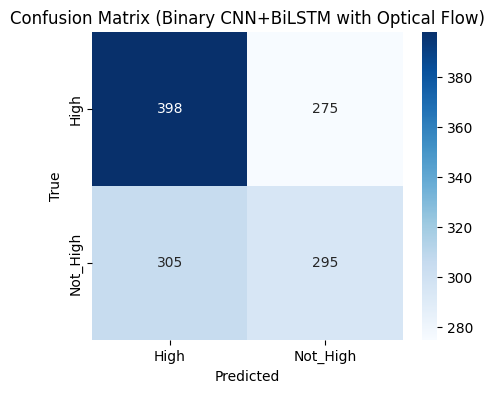

Binary classifier saved to: /content/drive/MyDrive/CricVision/cnn_bilstm_binary_classifier.keras


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import cv2, os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# === CONFIG ===
frames_root = "/content/drive/MyDrive/All_Frames"
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
save_model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_binary_classifier.keras"

# === LOAD AND PREP DATA ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)

pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]
score_cols = ["score_1","score_2","score_3","score_4","score_5"]
df["avg_score"] = df[score_cols].mean(axis=1)

# === Label creation: High vs Not High ===
def label_binary(x):
    return "High" if x > 6 else "Not_High"

df["label_class"] = df["avg_score"].apply(label_binary)
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label_class"])
y_classes = to_categorical(df["label_encoded"], num_classes=2)
print("Label distribution:\n", df["label_class"].value_counts())

# === Add motion energy and optical flow ===
motion_energy = df.groupby("phase_id")[pose_features].diff().pow(2).sum(axis=1).fillna(0)
df["motion_energy"] = motion_energy

# Compute optical flow magnitude
def optical_flow_magnitude(prev_img, next_img):
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    return np.mean(mag), np.std(mag)

magnitudes, stds = [], []
for pid, ph in tqdm(df.groupby("phase_id"), desc="Computing optical flow"):
    files = [os.path.join(frames_root, pid, fn) for fn in ph["frame_name"]]
    mag_list, std_list = [0], [0]
    for i in range(1, len(files)):
        img1, img2 = cv2.imread(files[i-1]), cv2.imread(files[i])
        if img1 is None or img2 is None:
            mag_list.append(0); std_list.append(0)
            continue
        m, s = optical_flow_magnitude(img1, img2)
        mag_list.append(m); std_list.append(s)
    magnitudes.extend(mag_list)
    stds.extend(std_list)
df["flow_mag_mean"], df["flow_mag_std"] = magnitudes, stds
print("Added motion and optical flow features.")

# === CNN EMBEDDINGS ===
cnn_model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((224,224,3), dtype=np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    return preprocess_input(img)

batch_size = 64
embeddings = []
paths = [os.path.join(frames_root, r["phase_id"], r["frame_name"]) for _, r in df.iterrows()]
for i in tqdm(range(0, len(paths), batch_size), desc="Extracting CNN features"):
    imgs = [load_and_preprocess_image(p) for p in paths[i:i+batch_size]]
    imgs = np.array(imgs, dtype=np.float32)
    emb = cnn_model.predict(imgs, verbose=0)
    embeddings.extend(emb)
cnn_features = np.array(embeddings)
print("Extracted CNN embeddings:", cnn_features.shape)

# === Combine features ===
scaler = StandardScaler()
pose_scaled = scaler.fit_transform(df[pose_features + ["motion_energy","flow_mag_mean","flow_mag_std"]])
combined_features = np.concatenate([pose_scaled, cnn_features], axis=1)
print("Combined feature shape:", combined_features.shape)

# === Create sequences ===
sequence_length = 8
seqs, labels = [], []
for pid, ph in df.groupby("phase_id"):
    Xp, yp = combined_features[ph.index], y_classes[ph.index]
    if len(Xp) < sequence_length:
        pad = sequence_length - len(Xp)
        Xp = np.concatenate([Xp, np.repeat([Xp[-1]], pad, axis=0)], axis=0)
        yp = np.concatenate([yp, np.repeat([yp[-1]], pad, axis=0)], axis=0)
    for i in range(len(Xp) - sequence_length + 1):
        seqs.append(Xp[i:i+sequence_length])
        labels.append(yp[i+sequence_length-1])
X, y = np.array(seqs), np.array(labels)
print("Sequences:", X.shape)

# === Class weights ===
classes = np.unique(df["label_encoded"])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["label_encoded"])
cw = dict(zip(classes, weights))
print("Class weights:", cw)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# === MODEL ===
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1), input_shape=(X.shape[1], X.shape[2])),
    layers.Bidirectional(layers.LSTM(64, dropout=0.1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='binary_crossentropy', metrics=['accuracy'])
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model.summary()

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[cb],
    class_weight=cw
)

# === EVALUATE ===
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nBinary Classification Report (High vs Not High):")
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Binary CNN+BiLSTM with Optical Flow)")
plt.show()

model.save(save_model_path)
print(f"Binary classifier saved to: {save_model_path}")


Loaded dataset: (32492, 19)
Binary classifier loaded successfully.
Using features: ['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle', 'shoulder_angle', 'hip_angle', 'left_arm_length', 'right_arm_length', 'left_leg_length', 'right_leg_length', 'torso_length', 'motion_energy']
Prepared 8482 phase sequences for inference.
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Merged predictions with truth: (8482, 4)

Phase-level Accuracy: 48.37%

Classification Report (Phase Level):
              precision    recall  f1-score   support

    Not High       0.48      0.87      0.61      4028
        High       0.53      0.14      0.22      4454

    accuracy                           0.48      8482
   macro avg       0.50      0.50      0.42      8482
weighted avg       0.51      0.48      0.41      8482



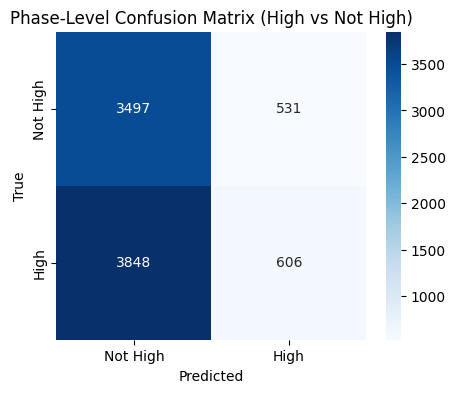

Final phase-level predictions saved to: /content/drive/MyDrive/CricVision/final_phase_level_predictions.csv


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# === CONFIG ===
data_path = "/content/drive/MyDrive/CricVision/training_dataset.csv"
model_path = "/content/drive/MyDrive/CricVision/cnn_bilstm_binary_classifier.keras"
output_csv = "/content/drive/MyDrive/CricVision/final_phase_level_predictions.csv"

# === LOAD DATA & MODEL ===
df = pd.read_csv(data_path)
df = df.sort_values(["phase_id", "frame_number"]).reset_index(drop=True)
print(f"Loaded dataset: {df.shape}")

model = load_model(model_path)
print("Binary classifier loaded successfully.")

# === RECREATE FEATURES ===
pose_features = [
    "left_elbow_angle","right_elbow_angle","left_knee_angle","right_knee_angle",
    "shoulder_angle","hip_angle","left_arm_length","right_arm_length",
    "left_leg_length","right_leg_length","torso_length"
]

# Motion energy (frame-to-frame angular change)
motion_energy = df.groupby("phase_id")[pose_features].diff().pow(2).sum(axis=1).fillna(0)
df["motion_energy"] = motion_energy

# Handle missing optical flow columns gracefully
optical_cols = ["flow_mag_mean", "flow_mag_std"]
available_optical_cols = [c for c in optical_cols if c in df.columns]

feature_cols = pose_features + ["motion_energy"] + available_optical_cols
print(f"Using features: {feature_cols}")

# Scale selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[feature_cols])

# === CREATE PHASE SEQUENCES ===
sequence_length = 8
phase_ids, sequences = [], []

for pid, ph in df.groupby("phase_id"):
    if len(ph) < sequence_length:
        Xp = np.repeat([scaled_features[ph.index[-1]]], sequence_length, axis=0)
    else:
        Xp = scaled_features[ph.index[-sequence_length:]]
    sequences.append(Xp)
    phase_ids.append(pid)

X_phase = np.array(sequences)
print(f"Prepared {len(X_phase)} phase sequences for inference.")

# === INFERENCE ===
y_pred = model.predict(X_phase, verbose=1)
y_labels = np.argmax(y_pred, axis=1)

# === AGGREGATE RESULTS ===
phase_df = pd.DataFrame({
    "phase_id": phase_ids,
    "pred_label": y_labels,
    "pred_prob_high": y_pred[:, 1]
})

# === ADD GROUND-TRUTH LABELS ===
score_cols = ["score_1","score_2","score_3","score_4","score_5"]
df["avg_score"] = df[score_cols].mean(axis=1)
df["true_label"] = np.where(df["avg_score"] > 6, 1, 0)

truth = df.groupby("phase_id")["true_label"].mean().round().astype(int).reset_index()
merged = pd.merge(phase_df, truth, on="phase_id", how="inner")
print(f"Merged predictions with truth: {merged.shape}")

# === EVALUATE AT PHASE LEVEL ===
acc = accuracy_score(merged["true_label"], merged["pred_label"])
print(f"\nPhase-level Accuracy: {acc*100:.2f}%")

print("\nClassification Report (Phase Level):")
print(classification_report(
    merged["true_label"],
    merged["pred_label"],
    target_names=["Not High", "High"]
))

cm = confusion_matrix(merged["true_label"], merged["pred_label"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not High", "High"],
            yticklabels=["Not High", "High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Phase-Level Confusion Matrix (High vs Not High)")
plt.show()

# === SAVE OUTPUT ===
merged.to_csv(output_csv, index=False)
print(f"Final phase-level predictions saved to: {output_csv}")


Loaded 8482 phase-level results
      Label  Precision    Recall  F1-score
0  Not High   0.476106  0.868173  0.614965
1      High   0.532982  0.136057  0.216777


<Figure size 600x400 with 0 Axes>

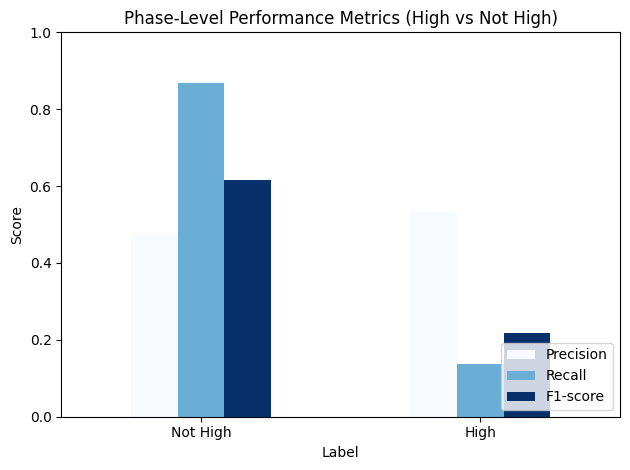

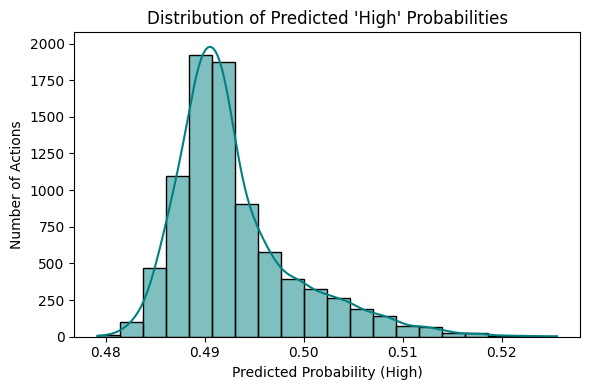

Saved metrics summary to Drive: final_metrics_summary.csv


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# === CONFIG ===
final_preds_path = "/content/drive/MyDrive/CricVision/final_phase_level_predictions.csv"

# === LOAD RESULTS ===
results = pd.read_csv(final_preds_path)
print(f"Loaded {results.shape[0]} phase-level results")

# === COMPUTE METRICS ===
y_true = results["true_label"]
y_pred = results["pred_label"]
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
labels = ["Not High", "High"]

metrics_df = pd.DataFrame({
    "Label": labels,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})
print(metrics_df)

# === BAR CHART: PRECISION / RECALL / F1 ===
plt.figure(figsize=(6,4))
metrics_df.set_index("Label")[["Precision","Recall","F1-score"]].plot(kind="bar", colormap="Blues", rot=0)
plt.title("Phase-Level Performance Metrics (High vs Not High)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# === HISTOGRAM: Prediction Probabilities ===
plt.figure(figsize=(6,4))
sns.histplot(results["pred_prob_high"], bins=20, kde=True, color="teal")
plt.title("Distribution of Predicted 'High' Probabilities")
plt.xlabel("Predicted Probability (High)")
plt.ylabel("Number of Actions")
plt.tight_layout()
plt.show()

# === SAVE METRICS SUMMARY ===
metrics_df.to_csv("/content/drive/MyDrive/CricVision/final_metrics_summary.csv", index=False)
print("Saved metrics summary to Drive: final_metrics_summary.csv")
